In [1]:
import pandas as pd
import numpy as np

# ===============================================================================
 #                     CARREGAMENTO DOS DADOS
 #===============================================================================
print("Carregando os arquivos csv")

df_orders = pd.read_csv('olist_orders_dataset.csv')
df_payments = pd.read_csv('olist_order_payments_dataset.csv')
df_customers = pd.read_csv('olist_customers_dataset.csv')

#===============================================================================
    #                     CRUZAMENTO DOS DADOS
#===============================================================================
print(" Fazendo o cruzamento das tabelas")

# 1. Juntar pedidos com pagamentos 
# Usamos 'order_id' como chave de cruzamento se o pedido existe nas duas tabelas, ele junta.
df_temp = df_orders.merge(df_payments, on='order_id')

#2. Juntar os resultados acima com a tabela de clientes
#Usamos 'customer_id' como chave para descobrir o 'customer_unique_id'
df_total = df_temp.merge(df_customers, on='customer_id')

#===============================================================================
    #                     LIMPEZA E ORGANIZAÇÃO DOS DADOS
#===============================================================================
print("⏳ Limpando e organizando...")

# 1. Conversão de Tipo
df_total['order_purchase_timestamp'] = pd.to_datetime(df_total['order_purchase_timestamp'])

# 2. Filtro de Negócio (Apenas entregues)
df_sales = df_total[df_total['order_status'] == 'delivered'].copy()

# 3. Seleção de Colunas
colunas_uteis = ['customer_unique_id', 'order_id', 'order_purchase_timestamp', 'payment_value']
df_sales = df_sales[colunas_uteis]

print("🔧 Corrigindo duplicidade de pagamentos...")
df_sales_clean = df_sales.groupby(['customer_unique_id', 'order_id', 'order_purchase_timestamp'])['payment_value'].sum().reset_index()

#===============================================================================
#                     RESULTADO FINAL DOS DADOS 
#===============================================================================

print(f"✅ SUCESSO! Base carregada.")
print(f"📊 Quantidade de Linhas (Vendas): {df_sales.shape[0]}")
print(f"📊 Quantidade de Colunas: {df_sales.shape[1]}")

# Mostra as primeiras 5 linhas para conferência
df_sales_clean.head()

Carregando os arquivos csv
 Fazendo o cruzamento das tabelas
⏳ Limpando e organizando...
🔧 Corrigindo duplicidade de pagamentos...
✅ SUCESSO! Base carregada.
📊 Quantidade de Linhas (Vendas): 100756
📊 Quantidade de Colunas: 4


,customer_unique_id,order_id,order_purchase_timestamp,payment_value
0,0000366f3b9a7992bf8c76cfdf3221e2,e22acc9c116caa3f2b7121bbb380d08e,2018-05-10 10:56:27,141.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,3594e05a005ac4d06a72673270ef9ec9,2018-05-07 11:11:27,27.19
2,0000f46a3911fa3c0805444483337064,b33ec3b699337181488304f362a6b734,2017-03-10 21:05:03,86.22
3,0000f6ccb0745a6a4b88665a16c9f078,41272756ecddd9a9ed0180413cc22fb6,2017-10-12 20:29:41,43.62
4,0004aac84e0df4da2b147fca70cf8255,d957021f1127559cd947b62533f484f7,2017-11-14 19:45:42,196.89


Engenharia de Atributos: Criação da Tabela RFM

Alteração de Granularidade: De "Pedidos" para "Clientes"

Contexto:

Atualmente, o dataset `df_sales` possui uma visão transacional uma linha por item/pedido. Para realizarmos a segmentação estratégica, precisamos transformar esses dados em uma visão comportamental (uma linha por cliente único).

Utilizaremos a técnica de agregação (`groupby`) pelo `customer_unique_id` para calcular as métricas fundamentais do RFM:

Recência (R):Quantos dias se passaram desde a última compra do cliente até a data de referência da análise. 
**(Hipótese: Quanto menor, maior a chance de engajamento).**

Frequência (F): Quantidade total de pedidos únicos realizados pelo cliente. 
**(Hipótese: Quanto maior, maior a lealdade).**

Monetário (M): Soma total do valor gasto (`payment_value`) em todos os pedidos. 
**(Hipótese: Quanto maior, maior o valor para a empresa).**


In [4]:
import datetime as dt

# ==============================================================================
#                  CALCULAR O RFM (Engenharia de Atributos)
# ==============================================================================

# 1. Definindo a Data de referência 
# Pegamos a data da ultima venda registrada na planilha e soma 1 dia. 
data_referencia = df_sales_clean['order_purchase_timestamp'].max() + dt.timedelta(days=1)
print(f"📅 Data de Referência para os cálculos: {data_referencia}")

# 2. Agrupando os dados por Cliente Único
# Aqui transformamos várias linhas de pedidos em uma linha única por cliente.

print("⏳ Calculando Recência, Frequência e Monetário...")

df_rfm = df_sales_clean.groupby('customer_unique_id').agg({
    # Coluna Original              # Função Matemática a aplicar
    'order_purchase_timestamp':    lambda x: (data_referencia - x.max()).days, # Recência: Data Ref - Última Compra dele
    'order_id':                    'nunique',                                  # Frequência: Contar quantos pedidos
    'payment_value':               'sum'                                       # Monetário: Somar o valor pago
})


# 3. Renomeando as colunas
# O pandas cria as colunas com os nomes antigos, mudaremos para os nomes técnicos.

df_rfm.rename(columns={
    'order_purchase_timestamp': 'recencia',
    'order_id':                 'frequencia',
    'payment_value':            'monetario'
}, inplace=True)

# ==============================================================================
#                       RESULTADO DO RFM
# ==============================================================================
print(f"✅ Tabela RFM criada com sucesso!")
print(f"📊 Clientes únicos processados {df_rfm.shape[0]}")

#verificando a amostra
df_rfm.head()


📅 Data de Referência para os cálculos: 2018-08-30 15:00:37
⏳ Calculando Recência, Frequência e Monetário...
✅ Tabela RFM criada com sucesso!
📊 Clientes únicos processados 93357


,recencia,frequencia,monetario
customer_unique_id,,,
0000366f3b9a7992bf8c76cfdf3221e2,112,1,141.90
0000b849f77a49e4a4ce2b2a4ca5be3f,115,1,27.19
0000f46a3911fa3c0805444483337064,537,1,86.22
0000f6ccb0745a6a4b88665a16c9f078,321,1,43.62
0004aac84e0df4da2b147fca70cf8255,288,1,196.89


Interpretação da Base RFM 

A tabela gerada acima altera a nossa visão de "Transacional" (pedidos) para "Comportamental" (clientes). Agora, cada linha resume o histórico de vida de um cliente único:

* ** Recência (R):** Dias desde a última compra.
    * *Lógica de Negócio:* Quanto **menor** o valor, mais "quente" e engajado é o cliente. Valores altos indicam risco de *Churn* (abandono).
* ** Frequência (F):** Quantidade de pedidos únicos realizados.
    * *Lógica de Negócio:* Quanto **maior**, maior a fidelidade. É o nosso termômetro de retenção.
* ** Monetário (M):** Total gasto acumulado em reais (R$).
    * *Lógica de Negócio:* Quanto **maior**, maior o valor financeiro (LTV - Lifetime Value) que o cliente trouxe para a empresa.


Diagnóstico da Distribuição (EDA)

Antes de aplicarmos qualquer algoritmo de Machine Learning (como o K-Means), precisamos entender a **"Física dos Dados"**:

1.  **Assimetria:** Será que temos uma distribuição equilibrada ou a regra 80/20 se aplica (poucos clientes gerando quase toda a receita)?
2.  **Outliers:** Existem valores extremos ("Baleias") que podem distorcer o cálculo de distância do algoritmo?

Vamos investigar essas propriedades estatísticas visualmente para decidir se precisamos aplicar transformações nos dados (como Logaritmo ou Padronização).

⏳ Gerando gráficos de distribuição...


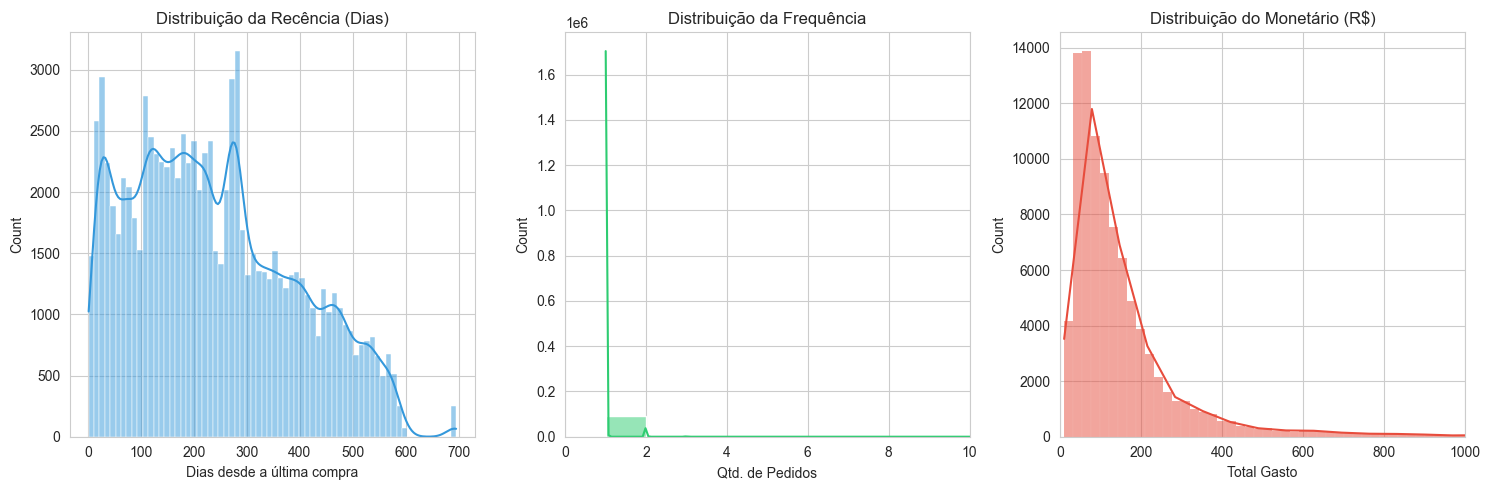


📊 Resumo Estatístico dos Dados:
           recencia    frequencia     monetario
count  93357.000000  93357.000000  93357.000000
mean     237.936673      1.033420    165.198772
std      152.584315      0.209099    226.314579
min        1.000000      1.000000      9.590000
25%      114.000000      1.000000     63.060000
50%      219.000000      1.000000    107.780000
75%      346.000000      1.000000    182.560000
max      695.000000     15.000000  13664.080000


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# ==============================================================================
#                  ANÁLISE EXPLORATÓRIA (VISUALIZAÇÃO)
# ==============================================================================
print("⏳ Gerando gráficos de distribuição...")

# Criando uma figura larga para colocar os 3 gráficos lado a lado
sns.set_style("whitegrid")
plt.figure(figsize=(15, 5))

# GRAFICO 1: RECÊNCIA 
plt.subplot(1, 3, 1) # Posição: 1
sns.histplot(df_rfm['recencia'], kde=True, color='#3498db') 
plt.title('Distribuição da Recência (Dias)')
plt.xlabel('Dias desde a última compra')

# GRAFICO 1: FREQUÊNCIA
plt.subplot(1, 3, 2) # Posição: 2
sns.histplot(df_rfm['frequencia'], kde=True, color='#2ecc71', binwidth=1) 
plt.title('Distribuição da Frequência')
plt.xlabel('Qtd. de Pedidos')
plt.xlim(0, 10) # Limitamos em 10 para ver melhor a maioria (zoom)

# GRAFICO 1: MONETÁRIO
plt.subplot(1, 3, 3) # Posição: 3
sns.histplot(df_rfm['monetario'], kde=True, color='#e74c3c') 
plt.title('Distribuição do Monetário (R$)')
plt.xlabel('Total Gasto')
plt.xlim(0, 1000) # Limitamos em R$ 1000 para evitar que os milionários estraguem o gráfico

# Ajuste automático de layout
plt.tight_layout()
plt.show()

# ==============================================================================
#                       ESTATÍSTICAS DESCRITIVAS
# ==============================================================================
print("\n📊 Resumo Estatístico dos Dados:")

# O .describe() mostra Média, Desvio Padrão, Mínimo e Máximo
print(df_rfm.describe())

Diagnóstico Estatístico e Visual

A análise dos histogramas e do resumo estatístico (`.describe`) revela padrões críticos que impactam diretamente a escolha e o pré-processamento do algoritmo:

1. O Desafio da Retenção (Frequência)

* **Visualmente:** O histograma verde mostra uma concentração massiva no número 1.
* **Estatisticamente:** A média de frequência é 1.03 e o 3º Quartil (75%) também é 1.0.
* **Insight de Negócio:** A Olist possui uma dificuldade extrema de fidelização. A vasta maioria da base comprou apenas uma única vez, o que torna a segmentação vital para identificar os poucos clientes recorrentes.

 2. A Disparidade de Valores (Monetário)
* **Visualmente:** O histograma vermelho apresenta uma "cauda longa" à direita (Assimetria Positiva).
* **Estatisticamente:** Enquanto a média de gastos é R$ 165,00, o valor máximo chega a **R$ 13.664,00**.
* **Insight de Negócio:** Existem "Baleias" (clientes de altíssimo valor) misturados com a massa que gasta pouco. Esses outliers são preciosos, mas matematicamente perigosos para modelos de distância.

---

O Problema Técnico: Escala e Assimetria

Identificamos dois obstáculos para o K-Means:
1.  **Escala:** A Frequência varia de 1 a 15, enquanto o Monetário vai até 13.000. O algoritmo daria peso excessivo ao dinheiro, ignorando a fidelidade.
2.  **Assimetria:** A distribuição não é normal (curva de sino). O K-Means assume clusters esféricos e sofre com distribuições muito tortas.

Solução em Duas Etapas
Para corrigir isso, aplicaremos um pipeline de tratamento:
1.  **Transformação Logarítmica (`np.log1p`):** Para comprimir os outliers e reduzir a assimetria da variável Monetário.
2.  **Padronização (`StandardScaler`):** Para colocar todas as variáveis na mesma régua matemática (Média 0, Desvio 1)


⚙️ Transformando os dados (Log + Scaler)...
✅ Dados Prontos! Veja como a estatística mudou (Média próx de 0):


,recencia,frequencia,monetario
count,93357.00,93357.00,93357.00
mean,-0.00,0.00,0.00
std,1.00,1.00,1.00
min,-4.79,-0.17,-2.93
25%,-0.45,-0.17,-0.70
50%,0.24,-0.17,-0.05
75%,0.73,-0.17,0.60
max,1.48,26.95,5.93



🔎 Rodando K-Means de 1 a 10 clusters...


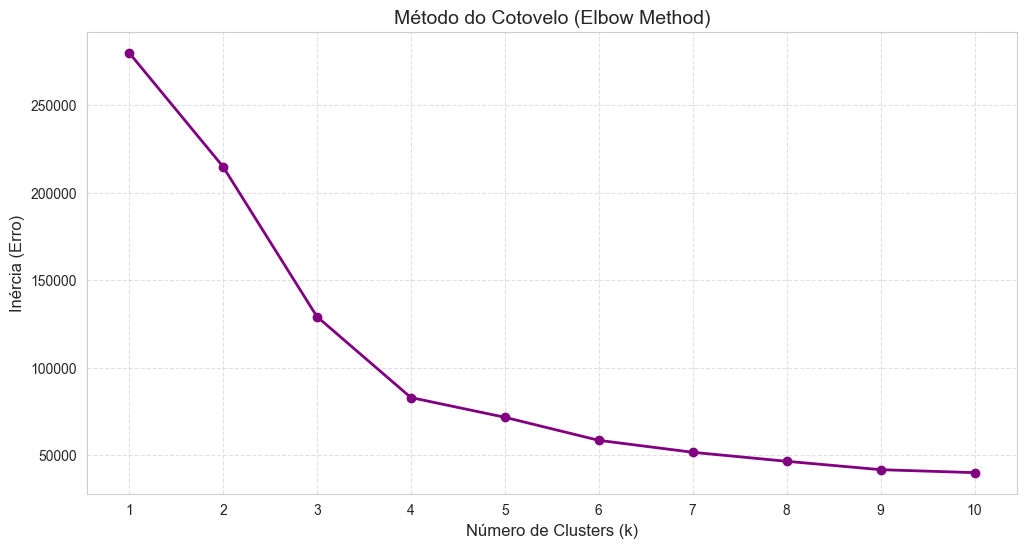

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# ==============================================================================
#            PRÉ-PROCESSAMENTO: LOGARITMO + PADRONIZAÇÃO
# ==============================================================================

print("⚙️ Transformando os dados (Log + Scaler)...")

# A. Aplicar Logaritmo (np.log1p)
# Isso "amassa" os outliers, trazendo quem gastou R$ 13k para perto da média
df_log = df_rfm[['recencia', 'frequencia', 'monetario']].apply(np.log1p)

# B. Aplicar StandardScaler
# Coloca todas as variáveis na mesma escala (Média ~0 e Desvio Padrão ~1)
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(df_log)

# Transformar de volta para DataFrame (para não perdermos os nomes das colunas)
df_scaled = pd.DataFrame(rfm_scaled, columns=['recencia', 'frequencia', 'monetario'])

print("✅ Dados Prontos! Veja como a estatística mudou (Média próx de 0):")
display(df_scaled.describe().round(2))

# ==============================================================================
#             O MÉTODO DO COTOVELO (ELBOW METHOD)
# ==============================================================================
print("\n🔎 Rodando K-Means de 1 a 10 clusters...")

inertia = []
k_range = range(1, 11)

for k in k_range:
    # init='k-means++' ajuda o modelo a convergir mais rápido
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
    kmeans.fit(df_scaled)
    inertia.append(kmeans.inertia_) # Inertia = Erro (Soma das distâncias ao quadrado)

# Plotando o Gráfico
plt.figure(figsize=(12, 6))
plt.plot(k_range, inertia, marker='o', linestyle='-', color='purple', linewidth=2)
plt.title('Método do Cotovelo (Elbow Method)', fontsize=14)
plt.xlabel('Número de Clusters (k)', fontsize=12)
plt.ylabel('Inércia (Erro)', fontsize=12)
plt.xticks(k_range)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

Definição do Número de Clusters 

Análise do Método do Cotovelo (Elbow Method)
Ao analisarmos o gráfico de inércia acima, observamos o comportamento da variância dos dados conforme aumentamos o número de grupos:

1. De 1 para 3 Clusters:** Ocorre uma queda vertiginosa no erro (Inércia). Isso indica que os dados possuem grupos naturais muito distintos que precisavam ser separados.

2. O "Cotovelo" no K=4: A partir de 4 clusters, a curva começa a se estabilizar ("deitar"). A redução do erro ao adicionar um 5º ou 6º cluster torna-se marginal (Diminishing Returns).

3.  Decisão de Negócio:

    * Escolher **3 clusters** seria generalista demais (perderíamos nuances).
    * Escolher **5 ou mais** aumentaria a complexidade operacional para o time de Marketing sem trazer ganho estatístico relevante.

Conclusão: O ponto ótimo (*Sweet Spot*) é K=4. Seguiremos com a segmentação da base em 4 perfis estratégicos.


In [9]:
from sklearn.cluster import KMeans

# ==============================================================================
#            TREINAMENTO DO MODELO FINAL (K=4)
# ==============================================================================
print("🚀 Treinando o modelo final com K=4 clusters...")
# 1. Inicializar e Treinar o Modelo
# random_state=42 garante que, se rodarmos de novo, os grupos serão os mesmos
kmeans_final = KMeans(n_clusters=4, init='k-means++', random_state=42)
kmeans_final.fit(df_scaled)
# 2. Atribuir os Clusters aos Clientes
# Importante: Criamos a coluna 'cluster' na base ORIGINAL (df_rfm) para interpretação
df_rfm['cluster'] = kmeans_final.labels_

print("✅ Segmentação concluída! Amostra da base classificada:")
display(df_rfm.head())

# ==============================================================================
#           4. ANÁLISE DE PERFIL (QUEM É QUEM?)
# ==============================================================================
# Agrupamos por cluster e calculamos a MÉDIA de cada atributo para entender o perfil
df_analise = df_rfm.groupby('cluster').mean()

# Adicionamos a contagem de clientes para saber o tamanho de cada grupo
df_analise['Qtd_Clientes'] = df_rfm['cluster'].value_counts()
df_analise['%_Base'] = (df_rfm['cluster'].value_counts(normalize=True) * 100).round(2)

print("\n📊 PERFIL MÉDIO DOS CLUSTERS (Ordenado por Gasto):")

# Ordenamos pelo Monetário para facilitar a identificação dos "VIPs"
display(df_analise.sort_values('monetario', ascending=False).round(2))
# ==============================================================================
#            ANÁLISE DE PERFIL (QUEM É QUEM?)
# ==============================================================================
# Agrupamos por cluster e calculamos a MÉDIA de cada atributo para entender o perfil
df_analise = df_rfm.groupby('cluster').mean()

# Adicionamos a contagem de clientes para saber o tamanho de cada grupo
df_analise['Qtd_Clientes'] = df_rfm['cluster'].value_counts()
df_analise['%_Base'] = (df_rfm['cluster'].value_counts(normalize=True) * 100).round(2)

print("\n📊 PERFIL MÉDIO DOS CLUSTERS (Ordenado por Gasto):")
# Ordenamos pelo Monetário para facilitar a identificação dos "VIPs"
display(df_analise.sort_values('monetario', ascending=False).round(2))

🚀 Treinando o modelo final com K=4 clusters...
✅ Segmentação concluída! Amostra da base classificada:


,recencia,frequencia,monetario,cluster
customer_unique_id,,,,
0000366f3b9a7992bf8c76cfdf3221e2,112,1,141.90,1
0000b849f77a49e4a4ce2b2a4ca5be3f,115,1,27.19,0
0000f46a3911fa3c0805444483337064,537,1,86.22,0
0000f6ccb0745a6a4b88665a16c9f078,321,1,43.62,0
0004aac84e0df4da2b147fca70cf8255,288,1,196.89,1



📊 PERFIL MÉDIO DOS CLUSTERS (Ordenado por Gasto):


,recencia,frequencia,monetario,Qtd_Clientes,%_Base
cluster,,,,,
2,220.29,2.11,308.59,2801,3.00
1,271.83,1.00,296.50,32111,34.40
3,42.11,1.00,133.01,16108,17.25
0,287.91,1.00,68.37,42337,45.35



📊 PERFIL MÉDIO DOS CLUSTERS (Ordenado por Gasto):


,recencia,frequencia,monetario,Qtd_Clientes,%_Base
cluster,,,,,
2,220.29,2.11,308.59,2801,3.00
1,271.83,1.00,296.50,32111,34.40
3,42.11,1.00,133.01,16108,17.25
0,287.91,1.00,68.37,42337,45.35


Interpretação dos Clusters e Estratégia de Marketing

Após o treinamento do modelo (k=4), identificamos quatro perfis distintos de clientes. Abaixo, detalhamos a "Persona" de cada grupo e a sugestão estratégica de ação.



Cluster 2: "Campeões (VIPs)"

* **Perfil:** É o único grupo com **Frequência média acima de 2** (2.11). Também possuem o maior Ticket Médio (R$ 308,00).
* **Tamanho:** Apenas **3%** da base.
* **Diagnóstico:** São os clientes mais valiosos da Olist. Eles provaram fidelidade e alto poder de compra.
* **Ação Recomendada:** Fidelização. Não ofereça descontos (eles já compram). Ofereça exclusividade, acesso antecipado a lançamentos e programas de "Indique um Amigo".

Cluster 3: "Novos Promissores"

* **Perfil:** Destaque para a **Recência baixíssima (42 dias)**. Acabaram de chegar, gastaram um valor razoável (R$ 133,00) mas compraram apenas 1 vez.
* **Tamanho:** **17%** da base.
* **Diagnóstico:** Clientes "quentes". O momento de agir é agora, antes que esfriem e virem estatística de Churn.
* **Ação Recomendada:** Ativação da 2ª Compra. Enviar ofertas de *Cross-Sell* (produtos complementares) ou um pequeno incentivo para a próxima compra nas próximas semanas.

Cluster 1: "Baleias em Risco (Alta Gastança, Baixa Frequência)"
* **Perfil:** Ticket Médio alto (R$ 296,00), quase igual aos VIPs, mas compraram apenas **uma vez** e já faz muito tempo (271 dias).
* **Tamanho:** **34%** da base.
* **Diagnóstico:** Desperdício de potencial. São clientes com dinheiro que tiveram uma experiência pontual e não voltaram.
* **Ação Recomendada:** Reconquista Agressiva. Oferecer produtos premium com descontos progressivos para trazê-los de volta. Investigar motivos de insatisfação (Pesquisa NPS).

Cluster 0: "Inativos / Baixo Valor"
* **Perfil:** O menor Ticket Médio (R$ 68,00), compraram uma única vez e faz muito tempo (287 dias).
* **Tamanho:** **45%** da base (A grande maioria).
* **Diagnóstico:** Clientes casuais que provavelmente buscavam apenas preço baixo. O custo para reativá-los individualmente pode ser maior que o lucro que trazem.
* **Ação Recomendada:** Automação de Baixo Custo. Manter na régua de e-mail marketing geral, mas evitar gastos com mídia paga (Ads) para este público.

🏷️ Atribuindo nomes comerciais aos clusters...
✅ Base Final Pronta!


,recencia,frequencia,monetario,cluster,Perfil
customer_unique_id,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,112,1,141.90,1,Baleias (Em Risco)
0000b849f77a49e4a4ce2b2a4ca5be3f,115,1,27.19,0,Inativos / Baixo Valor
0000f46a3911fa3c0805444483337064,537,1,86.22,0,Inativos / Baixo Valor
0000f6ccb0745a6a4b88665a16c9f078,321,1,43.62,0,Inativos / Baixo Valor
0004aac84e0df4da2b147fca70cf8255,288,1,196.89,1,Baleias (Em Risco)



📊 Gerando o mapa de clientes...


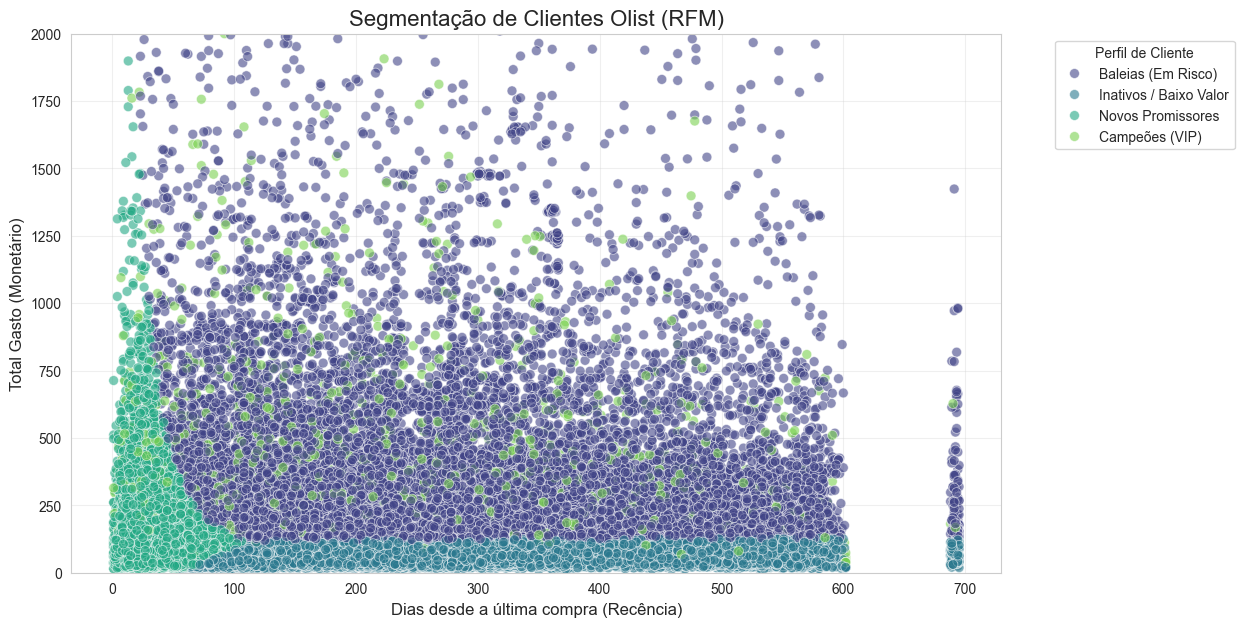

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# ==============================================================================
#           NOMEANDO OS CLUSTERS 
# ==============================================================================
print("🏷️ Atribuindo nomes comerciais aos clusters...")

# Dicionário de Nomes (Baseado na análise dos centróides que fizemos)
dict_perfis = {
    2: 'Campeões (VIP)',            # Alta Freq, Alto Gasto
    3: 'Novos Promissores',         # Recência Baixa (Chegou agora)
    1: 'Baleias (Em Risco)',        # Gastou muito, mas faz tempo (Churn)
    0: 'Inativos / Baixo Valor'     # Gastou pouco, faz tempo
}

# Criando a coluna de Perfil
df_rfm['Perfil'] = df_rfm['cluster'].map(dict_perfis)

# Mostrando a base final pronta para o Marketing
print("✅ Base Final Pronta!")
display(df_rfm.head())

# ==============================================================================
#           6. VISUALIZAÇÃO FINAL 
# ==============================================================================
print("\n📊 Gerando o mapa de clientes...")

plt.figure(figsize=(12, 7))

# Gráfico de Dispersão: Eixo X = Dias sem comprar, Eixo Y = Dinheiro Gasto
sns.scatterplot(data=df_rfm, x='recencia', y='monetario', hue='Perfil', palette='viridis', alpha=0.6, s=50)

plt.title('Segmentação de Clientes Olist (RFM)', fontsize=16)
plt.xlabel('Dias desde a última compra (Recência)', fontsize=12)
plt.ylabel('Total Gasto (Monetário)', fontsize=12)
plt.legend(title='Perfil de Cliente', bbox_to_anchor=(1.05, 1), loc='upper left') # Legenda fora do gráfico
plt.grid(True, alpha=0.3)

# Limitando o eixo Y para R$ 2.000 para visualizar melhor a maioria (sem os outliers extremos)
plt.ylim(0, 2000) 

plt.show()


df_rfm.to_csv('olist_segmentacao_final.csv')

Análise de Centróides 

A etapa mais crucial do projeto é a interpretação. O algoritmo K-Means agrupou os clientes matematicamente, mas cabe ao Cientista de Dados traduzir esses números em Comportamento de Negócio.

Para isso, analisamos os Centróides (a média de cada atributo por cluster) e utilizamos a técnica de comparação relativa:

1. O Grupo "VIP" (Cluster 2) 
* **A Evidência:** Foi o único grupo com **Frequência média > 2**. Além disso, possui o maior valor Monetário (R$ 308).
* **A Dedução:** Alta Frequência + Alto Gasto = **Cliente Leal e Valioso**.
* **Nome:** Campeões.

2. O Grupo "Novos" (Cluster 3) 
* **A Evidência:** O destaque absoluto é a **Recência de 42 dias**, enquanto todos os outros grupos têm médias acima de 200 dias.
* **A Dedução:** Baixa Recência indica que a compra foi recente. Como a Frequência é 1, são clientes que acabaram de chegar.
* **Nome:** Novos Promissores.

3. O Grupo "Baleias" (Cluster 1) 
* **A Evidência:** Gasto alto (R$ 296), tecnicamente empatado com os VIPs. Porém, a Frequência é 1 e a Recência é alta (271 dias).
* **A Dedução:** Gastaram muito dinheiro de uma só vez, mas não retornaram. No jargão de negócios, são "Whales" (Baleias) que estão em risco de Churn.
* **Nome:** Baleias (Em Risco).

4. O Grupo "Baixo Valor" (Cluster 0) 
* **A Evidência:** Possuem os piores indicadores em todas as frentes: Menor gasto (R$ 68) e alta recência.
* **A Dedução:** Clientes eventuais que buscavam preço baixo e não criaram vínculo com a marca.
* **Nome:** Inativos / Baixo Valor.


🕸️ Gerando Gráfico de Radar das Personas...


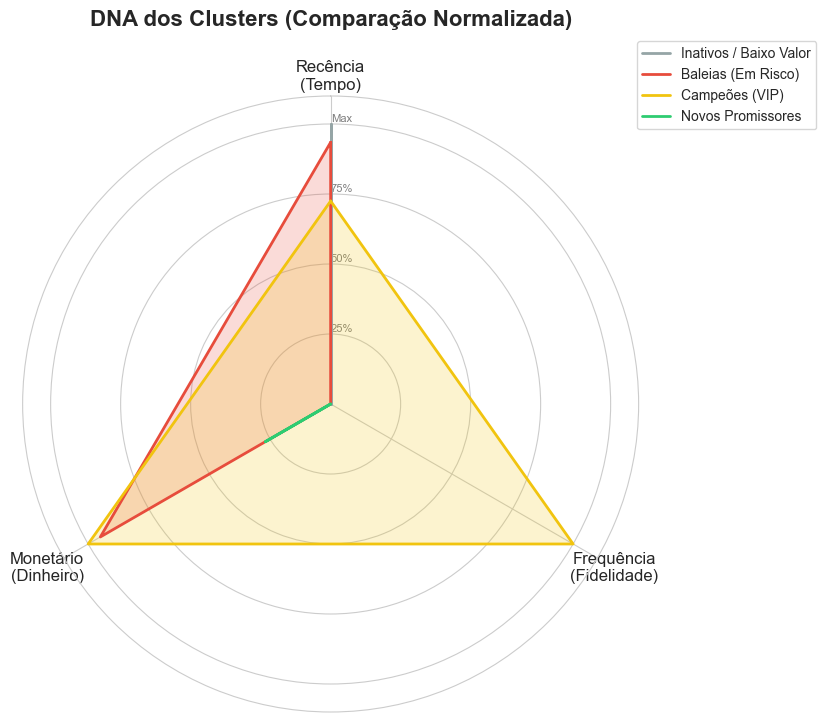

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

# ==============================================================================
#            GRÁFICO DE RADAR 
# ==============================================================================
print("🕸️ Gerando Gráfico de Radar das Personas...")

# 1. Preparar os dados para o Radar
# Pegamos as médias que calculamos no passo anterior (df_analise)
df_radar = df_analise.reset_index().copy()

# Definimos as colunas que queremos plotar
colunas_radar = ['recencia', 'frequencia', 'monetario']

# NORMALIZAÇÃO (Essencial para o Radar):
# Como Dinheiro é R$ 300 e Frequência é 2, precisamos colocar tudo na escala 0 a 1
scaler = MinMaxScaler()
df_radar[colunas_radar] = scaler.fit_transform(df_radar[colunas_radar])

# Adicionamos os nomes dos perfis
df_radar['Perfil'] = df_radar['cluster'].map(dict_perfis)

# 2. Configurar os Eixos do Radar (Matemática do Círculo)
categorias = ['Recência\n(Tempo)', 'Frequência\n(Fidelidade)', 'Monetário\n(Dinheiro)']
N = len(categorias)

# Calculando o ângulo de cada eixo
angulos = [n / float(N) * 2 * np.pi for n in range(N)]
angulos += angulos[:1] # Fechar o ciclo (repetir o primeiro ponto no fim)

# 3. Plotar
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw=dict(polar=True))

# Ajuste para o primeiro eixo ficar no topo (12 horas)
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)

# Desenhar os eixos e labels
plt.xticks(angulos[:-1], categorias, size=12)

# Ajustar os limites do eixo Y (raio)
ax.set_rlabel_position(0)
plt.yticks([0.25, 0.5, 0.75, 1.0], ["25%", "50%", "75%", "Max"], color="grey", size=8)
plt.ylim(0, 1.1)

# 4. Desenhar cada Perfil
# Cores estratégicas: VIP (Dourado/Amarelo), Novos (Verde), Baleias (Vermelho), Inativos (Cinza)
cores_map = {
    'Campeões (VIP)': '#f1c40f',       # Amarelo Ouro
    'Novos Promissores': '#2ecc71',    # Verde Esperança
    'Baleias (Em Risco)': '#e74c3c',   # Vermelho Alerta
    'Inativos / Baixo Valor': '#95a5a6' # Cinza Morto
}

for i, row in df_radar.iterrows():
    nome_perfil = row['Perfil']
    cor = cores_map.get(nome_perfil, 'blue') # Pega a cor do mapa, ou azul se não achar
    
    valores = row[colunas_radar].values.flatten().tolist()
    valores += valores[:1] # Fechar o ciclo
    
    # Plotar a linha
    ax.plot(angulos, valores, linewidth=2, linestyle='solid', label=nome_perfil, color=cor)
    # Preencher a área (com transparência)
    ax.fill(angulos, valores, alpha=0.2, color=cor)

# Legenda e Título
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=10)
plt.title('DNA dos Clusters (Comparação Normalizada)', size=16, y=1.1, weight='bold')

plt.show()

Mapeamento Visual dos Clusters 

O gráfico de dispersão acima nos permite visualizar as fronteiras de decisão que o algoritmo K-Means criou. Analisando os eixos Recência (X) e Monetário (Y), observamos padrões claros de comportamento:

1. A "Zona Quente" (Esquerda)
* **Quem está lá:** O cluster **Novos Promissores (Verde)**.
* **Análise:** Note como existe uma "parede" vertical nítida entre 0 e ~50 dias. O algoritmo isolou cirurgicamente os clientes recentes. Eles são a "safra nova" que precisa ser trabalhada para não virar inativa.

2. A "Massa Crítica" (Fundo)
* **Quem está lá:** O cluster **Inativos / Baixo Valor (Azul Escuro)**.
* **Análise:** Eles dominam a parte inferior do gráfico (baixo gasto) e se estendem por toda a linha do tempo à direita (alta recência). É o "oceano azul" de clientes que não geraram engajamento.

3. A Elite Financeira (Topo)
* **Quem está lá:** Os clusters **Campeões (Verde Claro)** e **Baleias (Roxo)**.
* **Análise:** Ambos ocupam a parte superior do gráfico (Ticket Alto). Visualmente, eles parecem misturados.
* **O Detalhe Técnico:** Por que eles se misturam? Porque este gráfico é 2D (apenas Tempo e Dinheiro). A diferença crucial entre um *Campeão* e uma *Baleia* é a **Frequência** (quantas vezes comprou). Como a frequência não está visível neste eixo, eles parecem vizinhos, mas comportamentalmente são muito diferentes (o Campeão volta, a Baleia não).

---
**Conclusão Visual:** A segmentação foi bem sucedida em separar clientes recentes, clientes de baixo valor e clientes de alto valor. A distinção final entre os dois grupos de alto valor (VIP vs Baleia) é dada pela fidelidade (Frequência), que confirmamos na análise dos centróides.